# A simple algorithm for generating streamflow networks for grid‐based, macroscale hydrological models
https://doi.org/10.1002/(SICI)1099-1085(19990615)13:8%3C1269::AID-HYP806%3E3.0.CO;2-R

A simple algorithm for generating streamflow networks for macroscale hydrological models (MHMs) from digital elevation models (DEMs) is presented. Typically these hydrological models are grid based, with the simulated runoff produced within each cell routed through a stream network which connects the centers of cells in the direction of the major streams. Construction of such stream networks is a time consuming task, which has generally been done by hand with the aid of maps. Results indicate that the algorithm works satisfactorily in areas of both high and low relief, and for a wide range of model cell resolutions, although some manual adjustments may be necessary.

In [11]:
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from rasterio import mask
from tqdm import notebook
import numpy as np
import pandas as pd
import shapely

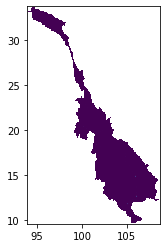

<AxesSubplot:>

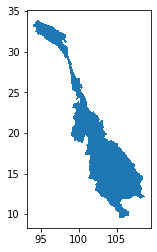

In [2]:
flowacc_path = '../data_nongit/mekong_flowaccumulation.tif'
flowacc_rast = rio.open(flowacc_path)

gdf = gpd.read_file('../data_nongit/mekong_grid.shp')

flowacc = flowacc_rast.read(1)
show(flowacc_rast)
gdf.plot()

In [3]:
# plt.imshow(flowacc == flowacc.max())   # As predicted, the highest accumulation pixel is at the edge.
# yleft, yright = flowacc.shape[0]/3, flowacc.shape[0]*2/3
# xup, xbot = flowacc.shape[1]/3, flowacc.shape[1]*2/3
# plt.axvline(yleft, color='red')
# plt.axvline(yright, color='red')
# plt.axhline(xup, color='red')
# plt.axhline(xbot, color='red')

In [63]:
class GridCell:
    def __init__(self, geom, rast):
        """
        geom is a geopandas object, single polygon which can be used to clip rasters
        rast is a rasterio raster object
        """
        self._geom = geom["geometry"]
        self._id = geom.name
        self._cellsize = 0.0625
        
        self.src = rast
        
        self.direction_dict = {
            1: 'N',
            2: 'NE',
            3: 'E',
            4: 'SE',
            5: 'S',
            6: 'SW',
            7: 'W',
            8: 'NW'
        }
        self.direction_dict_r = {
            'N': 1,
            'NE': 2,
            'E': 3,
            'SE': 4,
            'S': 5,
            'SW': 6,
            'W': 7,
            'NW': 8
        }
        
        self.determine_direction()
#         self.clipped = self.clip()
#         self._leftlim = int(self.clipped.shape[1] * 1/3)
#         self._rightlim = int(self.clipped.shape[1] * 2/3)
#         self._toplim = int(self.clipped.shape[0] * 1/3)
#         self._bottomlim = int(self.clipped.shape[0] * 2/3)
        
#         self.edges = (0, self.clipped.shape[0]-1, self.clipped.shape[1]-1)
        
#         self.exit = self.where()
        
    def determine_direction(self):
        self.clipped = self.clip()
        self._leftlim = int(self.clipped.shape[1] * 1/3)
        self._rightlim = int(self.clipped.shape[1] * 2/3)
        self._toplim = int(self.clipped.shape[0] * 1/3)
        self._bottomlim = int(self.clipped.shape[0] * 2/3)
        
        self.edges = (0, self.clipped.shape[0]-1, self.clipped.shape[1]-1)

        self.exit = self.where()
        
        self.griddirection = self.direction()
        
        if self.griddirection in (2, 4, 6, 8):
            neighbour_geom = self.get_neighbour(self.griddirection)
            
            clipped = self.clip(neighbour_geom)
            exit_x, exit_y = self.where(clipped)
            
            neighbour_d = None
            
            if exit_y <= clipped.shape[1]/2:
                neighbour_d = 'N'
            else:
                neighbour_d = 'S'
            
            if exit_x <= clipped.shape[0]/2:
                neighbour_d = neighbour_d+'W'
            else:
                neighbour_d = neighbour_d+'E'
            
            current_d = self.direction_dict[self.griddirection]
            
            self.griddirection = self.direction_dict_r[self.lookdeeper(current_d, neighbour_d)]
        
        return self.griddirection
            
            
    
    def clip(self, geom=None, write=False, savepath=None):
        if geom is None:
            geom = self._geom
        masked_band, masked_transform = mask.mask(self.src, [geom], crop=True)

        return masked_band[0]
    
    def where(self, clipped=None):
        if clipped is None:
            clipped = self.clipped
        wh = np.where(clipped == clipped.max())
        return wh[0][0], wh[1][0]
    
    def clean(self):
        os.remove(self.clipped)
    
    def clean_exit(self):
        return (self.exit[0] in self.edges) or (self.exit[1] in self.edges)
    
    def direction(self):
        directions = {
            'N': 1,
            'NE': 2,
            'E': 3,
            'SE': 4,
            'S': 5,
            'SW': 6,
            'W': 7,
            'NW': 8,
            'dirty': 0
        }
        if not self.clean_exit():
            return directions['dirty']
        else:
            y, x = self.exit
            
            if x < self._leftlim:
                if y < self._toplim:
                    return directions['NW']
                elif y < self._bottomlim:
                    return directions['W']
                else:
                    return directions['SW']
            elif x < self._rightlim:
                if y < self._toplim:
                    return directions['N']
                else:
                    return directions['S']
            else:
                if y < self._toplim:
                    return directions['NE']
                elif y < self._bottomlim:
                    return directions['E']
                else:
                    return directions['SE']
                
    def get_neighbour(self, direction):
        if direction == 2:        # NE
            return shapely.affinity.translate(self._geom, xoff=self._cellsize/2, yoff=self._cellsize/2)
        elif direction == 4:      # SE
            return shapely.affinity.translate(self._geom, xoff=self._cellsize/2, yoff=-self._cellsize/2)
        elif direction == 6:      # SW
            return shapely.affinity.translate(self._geom, xoff=-self._cellsize/2, yoff=-self._cellsize/2)
        elif direction == 8:      # NW
            return shapely.affinity.translate(self._geom, xoff=-self._cellsize/2, yoff=self._cellsize/2)
        
    def lookdeeper(self, current, neighbour):
        result = None
        if current == 'NE':
            if neighbour == 'NW':
                result = 'N'
            elif neighbour == 'SE':
                result = 'E'
            else:
                result = current
        elif current == 'SE':
            if neighbour == 'NE':
                result = 'E'
            elif neighbour == 'SW':
                result = 'S'
            else:
                result = current
        elif current == 'SW':
            if neighbour == 'NW':
                result = 'W'
            elif neighbour == 'SE':
                result = 'S'
            else:
                result = current
        elif current == 'NW':
            if neighbour == 'NE':
                result = 'N'
            elif neighbour == 'SW':
                result = 'W'
            else:
                result = current
        return result
    
class Basin:
    def __init__(self, path):
        self._path = path
        
        self._gdf = gpd.read_file(path)
        
        self._exits = {
            'i': [],
            'x': [],
            'y': [],
            'clean_exit': [],
            'dir': [],
            'id': []
        }
    
    def calculate_directions(self):
        for i in range(self._gdf.shape[0]):
            gc = GridCell(gdf.iloc[i, :], flowacc_rast)
            self._exits['id'].append(gdf.loc[i, ["OBJECTID"]].values[0])
            self._exits['i'].append(i)
            self._exits['x'].append(gc.exit[0])
            self._exits['y'].append(gc.exit[1])
            self._exits['clean_exit'].append(gc.clean_exit())
            self._exits['dir'].append(gc.direction())

        
    def __str__(self):
        return f"Basin<{os.path.split(self._path)[-1]} : {self._gdf.shape[0]} features>"
    
    def __repr__(self):
        return self.__str__()

In [64]:
# gc = GridCell(gdf.iloc[0, :])
# gdf.iloc[1000, :].geometry.union(gdf.iloc[1001, :].geometry)
geom = gdf.iloc[1000, :].geometry
transform = shapely.affinity.translate(geom, xoff=0.0625/2, yoff=0.0625/2, zoff=0.0)
# geom
# transform.union(geom)
print(geom.centroid)
print(transform.centroid)

POINT (103.8308333329579 12.07499999996183)
POINT (103.8620833329579 12.10624999996183)


In [66]:
exits = {
    'i': [],
    'x': [],
    'y': [],
    'clean_exit': [],
    'dir': [],
    'id': []
}

with notebook.tqdm(total=gdf.shape[0]) as pbar:
    for i in range(gdf.shape[0]):
        gc = GridCell(gdf.iloc[i, :], flowacc_rast)
        exits['id'].append(gdf.loc[i, ["OBJECTID"]].values[0])
        exits['i'].append(i)
        exits['x'].append(gc.exit[0])
        exits['y'].append(gc.exit[1])
        exits['clean_exit'].append(gc.clean_exit())
        exits['dir'].append(gc.determine_direction())
        pbar.update(1)
        pbar.set_description(f'{i:05}: ({gc.exit[0]:03}, {gc.exit[1]:03}): {gc.clean_exit()} - {gc.direction()}')

  0%|          | 0/18217 [00:00<?, ?it/s]

In [67]:
import pandas as pd

df = pd.DataFrame(exits)
df.head()

,i,x,y,clean_exit,dir,id
0,0,70,74,True,5,184
1,1,68,44,False,0,185
2,2,31,0,True,7,186
3,3,49,57,False,0,187
4,4,44,45,False,0,188


In [68]:
df.groupby('dir').count()

,i,x,y,clean_exit,id
dir,,,,,
0,337,337,337,337,337
1,2644,2644,2644,2644,2644
2,1164,1164,1164,1164,1164
3,3891,3891,3891,3891,3891
4,1424,1424,1424,1424,1424
5,3648,3648,3648,3648,3648
6,1366,1366,1366,1366,1366
7,2853,2853,2853,2853,2853
8,890,890,890,890,890


In [69]:
gdf

,OBJECTID,Join_Count,TARGET_FID,Id,Id_1,gridcode,Shape_Leng,Shape_Area,geometry
0,184,1,183,0,4,1,115.833333,67.611342,"POLYGON ((105.29958 9.54375, 105.29958 9.60625..."
1,185,1,184,0,4,1,115.833333,67.611342,"POLYGON ((105.36208 9.54375, 105.36208 9.60625..."
2,186,1,185,0,4,1,115.833333,67.611342,"POLYGON ((105.42458 9.54375, 105.42458 9.60625..."
3,187,1,186,0,4,1,115.833333,67.611342,"POLYGON ((105.48708 9.54375, 105.48708 9.60625..."
4,188,1,187,0,4,1,115.833333,67.611342,"POLYGON ((105.54958 9.54375, 105.54958 9.60625..."
...,...,...,...,...,...,...,...,...,...
18212,92120,1,92119,0,4,1,115.833333,67.611342,"POLYGON ((94.67458 33.73125, 94.67458 33.79375..."
18213,92354,1,92353,0,4,1,115.833333,67.611342,"POLYGON ((94.42458 33.79375, 94.42458 33.85625..."
18214,92355,1,92354,0,4,1,115.833333,67.611342,"POLYGON ((94.48708 33.79375, 94.48708 33.85625..."
18215,92356,1,92355,0,4,1,115.833333,67.611342,"POLYGON ((94.54958 33.79375, 94.54958 33.85625..."


In [70]:
result = pd.merge(df, gdf, left_on='id', right_on='OBJECTID')[['i', 'x', 'y', 'dir', 'geometry']]
result

,i,x,y,dir,geometry
0,0,70,74,5,"POLYGON ((105.29958 9.54375, 105.29958 9.60625..."
1,1,68,44,0,"POLYGON ((105.36208 9.54375, 105.36208 9.60625..."
2,2,31,0,7,"POLYGON ((105.42458 9.54375, 105.42458 9.60625..."
3,3,49,57,0,"POLYGON ((105.48708 9.54375, 105.48708 9.60625..."
4,4,44,45,0,"POLYGON ((105.54958 9.54375, 105.54958 9.60625..."
...,...,...,...,...,...
18212,18212,68,0,7,"POLYGON ((94.67458 33.73125, 94.67458 33.79375..."
18213,18213,16,71,4,"POLYGON ((94.42458 33.79375, 94.42458 33.85625..."
18214,18214,10,74,0,"POLYGON ((94.48708 33.79375, 94.48708 33.85625..."
18215,18215,16,10,6,"POLYGON ((94.54958 33.79375, 94.54958 33.85625..."


In [71]:
gpd.GeoDataFrame(result).to_file("./directions_complete_bart.geojson", driver="GeoJSON")

In [72]:
result.y.max()

74

In [73]:
result.x.max()

74